In [2]:
%matplotlib inline

import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

#### Globals

In [4]:
PATH_PIPE = '../src/'
PATH_RAW = '../data/raw_data/'
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'
PATH_RESULTS = '../results/'

MULTICLASS = [0, 1, 2, 3]
BINARY = [0, 1]
MULTICLASS_NUM = [0, 1, 2, 3]
BINARY_NUM = [0, 1]

MODEL_NAME = 'bert-base-uncased'
MAXLEN = 150
MAXFEATURES = 10000
BATCH_SIZE = 6

## Load data

Either with separate train and test files or...

In [4]:
train = pd.read_csv(PATH_DATA + "CRC_2880_train.csv")
test = pd.read_csv(PATH_DATA + "CRC_800_test.csv")
val = pd.read_csv(PATH_DATA + "CRC_320_val.csv")

X_train, y_train, y_bin_train = train['text_review'], train['tag'], train['bin_tag']
X_val, y_val, y_bin_val = val['text_review'], val['tag'], val['bin_tag']
X_test, y_test, y_bin_test = test['text_review'], test['tag'], test['bin_tag']

... with only one file.

In [110]:
data = pd.read_csv(PATH_DATA + "2840_full_data.csv")

# Prevent missing values
data = data.dropna(subset=['tag'])

X, y, y_bin = data['text_review'], data['tag'], data['bin_tag']

X_train, X_test, y_train, y_test =  [np.asarray(x) for x in train_test_split(X, y_bin, test_size=0.25, random_state=42)]
X_train, X_val, y_train, y_val = [np.asarray(x) for x in train_test_split(X_train, y_train, test_size=0.1, random_state=42)]

## Load model and preprocess

In [8]:
# Setup the text transformer from ktrain
t = text.Transformer(MODEL_NAME, maxlen=MAXLEN, class_names=BINARY)

# Special preprocessing step
trn = t.preprocess_train(X_train, y_bin_train)
val = t.preprocess_test(X_val, y_bin_val)

# Model generation
model = t.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 62
	95percentile : 241
	99percentile : 500


preprocessing test...
language: en
test sequence lengths:
	mean : 65
	95percentile : 225
	99percentile : 591


We get a Learner object that wraps training, tuning and validating

In [9]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

## Training and tuning

Tries different learning rates for pre-tuning

simulating training for different learning rates... this may take a few moments...
Train for 480 steps
336/480 [====================>.........] - ETA: 10:43 - loss: 0.9754 - accuracy: 0.5828

done.
Visually inspect loss plot and select learning rate associated with falling loss


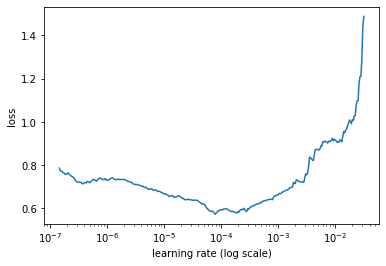

In [10]:
learner.lr_find(show_plot=True, max_epochs=1)

#### Training

`fit_onecycle` gradually increases the learning rate for half of the training and then decreases it until the end.

`fit` is used with SGDR learning rate schedule.

`autofit` uses a triangular learning rate policy

In [11]:
learner.fit_onecycle(5e-5, 2)

#learner.fit(0.001, 3, cycle_len=1, cycle_mult=2)

#learner.autofit(0.001, 1)



begin training using onecycle policy with max lr of 5e-05...
Train for 480 steps, validate for 10 steps
Epoch 1/2
480/480 [==============================] - 2267s 5s/step - loss: 0.4888 - accuracy: 0.7733 - val_loss: 0.4192 - val_accuracy: 0.8062
Epoch 2/2
480/480 [==============================] - 2482s 5s/step - loss: 0.3086 - accuracy: 0.8729 - val_loss: 0.3554 - val_accuracy: 0.8438


Checking which _n_ samples induced the strongest loss.

In [35]:
learner.top_losses(n=10, preproc=t)

[(108, 5.186967, 0, 2),
 (242, 5.1330605, 0, 2),
 (146, 4.801009, 0, 2),
 (265, 4.43287, 0, 2),
 (125, 4.363222, 0, 1),
 (255, 3.7513657, 1, 2),
 (0, 3.2437513, 0, 3),
 (129, 3.1956239, 1, 2),
 (52, 3.165217, 1, 2),
 (45, 3.0422184, 1, 2)]

Validate on validation data. Outputs an sklearn classification report.

In [12]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       155
           1       0.81      0.91      0.86       165

    accuracy                           0.84       320
   macro avg       0.85      0.84      0.84       320
weighted avg       0.85      0.84      0.84       320



array([[120,  35],
       [ 15, 150]])

## Prediction

Loading a fine-tuned model

In [5]:
predictor = ktrain.load_predictor(PATH_MODELS + 'final-bert-bin-2epoch')

OSError: Error no file named ['pytorch_model.bin', 'tf_model.h5'] found in directory ../../models/final-bert-bin-2epoch or `from_pt` set to False

Saving the fine-tuned model

In [14]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [56]:
cthree = pd.read_csv(PATH_DATA+'YNACC.csv')

X_cthree = [str(x) for x in cthree['text_review']]
y_cthree = cthree['bin_tag']

In [57]:
y_pred = predictor.predict(np.asarray(X_cthree))

In [58]:
print("Accuracy:", accuracy_score(y_cthree, y_pred))
print("F1 Score:", f1_score(y_cthree, y_pred, average='weighted'))
report = classification_report(y_cthree, y_pred, output_dict=True)
print(classification_report(y_cthree, y_pred))
print(confusion_matrix(y_cthree, y_pred))

Accuracy: 0.5205088835270892
F1 Score: 0.4273627655563279
              precision    recall  f1-score   support

           0       0.50      0.94      0.65     10983
           1       0.71      0.13      0.22     11812

    accuracy                           0.52     22795
   macro avg       0.60      0.54      0.44     22795
weighted avg       0.61      0.52      0.43     22795

[[10359   624]
 [10306  1506]]


In [59]:
pd.DataFrame(report).transpose().to_csv(PATH_RESULTS+'bin-bert-YNACC.csv', index=False)

#### On the SFU OCC corpus (binary classification only)

In [34]:
new_data = pd.read_csv(PATH_DATA + 'SOCC.csv')
new_data = new_data.loc[:, ['comment_text', 'is_constructive']]
new_data['is_constructive'] = new_data.loc[:, 'is_constructive'].map({'no': 'Not Constructive',
                                                                      'yes': 'Constructive'})

X_new, y_new = np.asarray(new_data['comment_text']), np.asarray(new_data['is_constructive'])

In [125]:
#predictor.predict(data, return_proba=True)
y_pred = predictor.predict(X_test)

In [128]:
y_new_corr = ['Constructive' if x == 1 else 'Not constructive' for x in y_test]

In [137]:
print("Accuracy:", accuracy_score(y_new_corr, y_pred))
print("F1 Score:", f1_score(y_new_corr, y_pred, average='weighted'))
report = classification_report(y_new_corr, y_pred, output_dict=True)
print(classification_report(y_new_corr, y_pred))

Accuracy: 0.8107344632768362
F1 Score: 0.808132023420109
                  precision    recall  f1-score   support

    Constructive       0.78      0.90      0.84       380
Not constructive       0.86      0.70      0.78       328

        accuracy                           0.81       708
       macro avg       0.82      0.80      0.81       708
    weighted avg       0.82      0.81      0.81       708



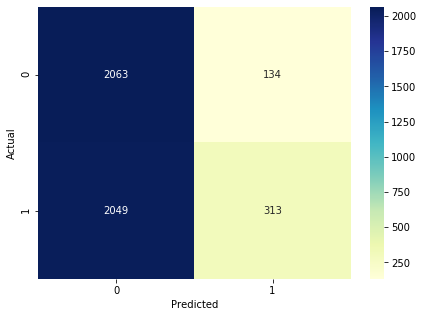

In [55]:
conf_mat = confusion_matrix(y_cthree, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.set_xticklabels([0, 1])

plt.show()

#fig.savefig(PATH_IMAGES + "Distilbert_1_epoch_SOCC.png", dpi=300, quality=95, format='png', bbox_inches='tight')

#### Saving the model

In [18]:
predictor.save(PATH_MODELS + 'final-bert-bin-2epoch')

Visualize the weight of words in classification (not workng on Colab)

In [63]:
#!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /private/var/folders/l5/nffr1ly16_xb_5mt_4fng4zr0000gn/T/pip-req-build-ctaal_ab
  Running command git clone -q https://github.com/amaiya/eli5 /private/var/folders/l5/nffr1ly16_xb_5mt_4fng4zr0000gn/T/pip-req-build-ctaal_ab
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Using cached graphviz-0.13.2-py2.py3-none-any.whl (17 kB)
  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=106682 sha256=4b52f3dedc9c3e058d4a6b387980c74a9f3150d37c64259b1fedd7d1e965dcb4
  Stored in directory: /private/var/folders/l5/nffr1ly16_xb_5mt_4fng4zr0000gn/T/pip-ephem-wheel-cache-kjhfgjfb/wheels/93/23/c2/479f99e6e981887ac70af72d4ff763471acf7184d1b80a9268
Successfully built eli5
You should consider upgra

In [64]:
predictor.explain("This is a very nice dress")